_Machine Learning Dr.Aliyari_


**Masih Mokhtari**

**40211454**
****
_mini project $2$_

$Q2$

In [91]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import seaborn as sns

%matplotlib inline

from scipy.io import loadmat
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.random import set_seed
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import KFold, StratifiedKFold

set_seed(54)
set_random_seed(54)

In [92]:
# Normal dataset
!wget -q https://engineering.case.edu/sites/default/files/99.mat
# Inner-Race-falut dataset
!wget -q https://engineering.case.edu/sites/default/files/107.mat
# Ball-falut dataset
!wget -q https://engineering.case.edu/sites/default/files/120.mat
# Outer-race-falut dataset
!wget -q https://engineering.case.edu/sites/default/files/132.mat

In [93]:
# Loading normal data
data_n = loadmat('99.mat')
cols_n = list(data_n.keys())[-4:]

# Loading inner race fault data
data_fi = loadmat('107.mat')
cols_fi = list(data_fi.keys())[-4:-1]

# Loading ball normal data
data_fb = loadmat('120.mat')
cols_fb = list(data_fb.keys())[-4:]

# Loading outer race fault data
data_fo = loadmat('132.mat')
cols_fo = list(data_fo.keys())[-4:-1]

In [94]:
print(f'normal data consists of {cols_n}', end='\n\n')
print(f'inner race fault data consista of {cols_fi}', end='\n\n')
print(f'ball fault data consists of {cols_fb}', end='\n\n')
print(f'outer race fault data consists of {cols_fo}')

normal data consists of ['X098_DE_time', 'X098_FE_time', 'X099_DE_time', 'X099_FE_time']

inner race fault data consista of ['X107_DE_time', 'X107_FE_time', 'X107_BA_time']

ball fault data consists of ['X120_DE_time', 'X120_FE_time', 'X120_BA_time', 'X120RPM']

outer race fault data consists of ['X132_DE_time', 'X132_FE_time', 'X132_BA_time']


In [95]:
# Choosing the right data
data_n = data_n['X099_DE_time']
data_fi = data_fi['X107_DE_time']
data_fb = data_fb['X120_DE_time']
data_fo = data_fo['X132_DE_time']

In [96]:
M = 1000
N = 200
signals = {'normal': data_n, 'inner fault': data_fi,
           'ball fault': data_fb, 'outter fault': data_fo}
data_names = signals.keys()
matrices = dict()
for i,name in enumerate(data_names):

    mat = np.zeros((M,N))
    for j in range(M):

        mat[j,:] = signals[name][j:j+N].reshape(-1,)
    matrices[name] = mat

In [97]:
met_name = matrices.keys()
for i, n in enumerate(met_name):

    print(f'From {n} data, {matrices[n].shape[0]} signals with length of {matrices[n].shape[1]} are extracted')

From normal data, 1000 signals with length of 200 are extracted
From inner fault data, 1000 signals with length of 200 are extracted
From ball fault data, 1000 signals with length of 200 are extracted
From outter fault data, 1000 signals with length of 200 are extracted


In [98]:
# Class for calculating features
class Features:

    def __init__(self,matrix):
        self.matrix = matrix
        self._extract()

    def _extract(self):

        self.features = {
            'standard deviation': stats.tstd(self.matrix, axis=1),
            'peak': np.max(self.matrix, axis=1),
            'skewness': stats.skew(self.matrix, axis=1),
            'mean': np.mean(self.matrix, axis=1),
            'absolute mean': np.mean(np.abs(self.matrix), axis=1),
            'root mean square': np.sqrt(np.mean(np.square(self.matrix), axis=1)),
            'square root mean': np.square(np.mean(np.sqrt(np.abs(self.matrix)), axis=1)),
            'kurtosis': stats.kurtosis(self.matrix, axis=1),
            'crest factor': np.max(self.matrix, axis=1) / np.sqrt(np.mean(np.square(self.matrix), axis=1)),
            'clearance factor': np.max(self.matrix, axis=1) / np.square(np.mean(np.sqrt(np.abs(self.matrix)), axis=1)),
            'peak to peak': np.max(self.matrix, axis=1) - np.min(self.matrix, axis=1),
            'shape factor': np.sqrt(np.mean(np.square(self.matrix), axis=1)) / np.mean(np.abs(self.matrix), axis=1),
            'impact factor': np.sqrt(np.mean(np.square(self.matrix), axis=1)) / np.mean(np.abs(self.matrix), axis=1),
            'impulse factor': np.abs(np.mean(self.matrix, axis=1)) / np.mean(np.abs(self.matrix), axis=1)
        }

    def __getitem__(self,key):
        return self.features[key]


feature_dic = dict()
for n in met_name:

    feature_dic[n] = Features(matrices[n])

In [99]:
data_frames = dict()
for i,n in enumerate(met_name):

    data_frames[n] = pd.DataFrame(feature_dic[n].features)
    data_frames[n]['label'] = i
    print(f'Label of \'{n}\' data is {i}')

# Stacking both datasets
df = pd.concat ([data_frames[n] for n in met_name], ignore_index=True)
df.head()

Label of 'normal' data is 0
Label of 'inner fault' data is 1
Label of 'ball fault' data is 2
Label of 'outter fault' data is 3


,standard deviation,peak,skewness,mean,absolute mean,root mean square,square root mean,kurtosis,crest factor,clearance factor,peak to peak,shape factor,impact factor,impulse factor,label
0,0.065162,0.179826,-0.102434,0.016275,0.051197,0.067005,0.041341,0.205579,2.683775,4.349826,0.355481,1.308760,1.308760,0.317890,0
1,0.065124,0.179826,-0.101089,0.016218,0.051140,0.066955,0.041293,0.211600,2.685784,4.354910,0.355481,1.309248,1.309248,0.317125,0
2,0.065046,0.179826,-0.095520,0.016050,0.050972,0.066839,0.041131,0.224659,2.690446,4.371997,0.355481,1.311286,1.311286,0.314875,0
3,0.065087,0.179826,-0.092039,0.015959,0.051063,0.066857,0.041302,0.216531,2.689711,4.353963,0.355481,1.309313,1.309313,0.312538,0
4,0.065158,0.179826,-0.091184,0.015882,0.051140,0.066907,0.041377,0.205829,2.687688,4.346023,0.355481,1.308321,1.308321,0.310557,0


In [129]:
df

,standard deviation,peak,skewness,mean,absolute mean,root mean square,square root mean,kurtosis,crest factor,clearance factor,peak to peak,shape factor,impact factor,impulse factor,label
0,0.065162,0.179826,-0.102434,0.016275,0.051197,0.067005,0.041341,0.205579,2.683775,4.349826,0.355481,1.308760,1.308760,0.317890,0
1,0.065124,0.179826,-0.101089,0.016218,0.051140,0.066955,0.041293,0.211600,2.685784,4.354910,0.355481,1.309248,1.309248,0.317125,0
2,0.065046,0.179826,-0.095520,0.016050,0.050972,0.066839,0.041131,0.224659,2.690446,4.371997,0.355481,1.311286,1.311286,0.314875,0
3,0.065087,0.179826,-0.092039,0.015959,0.051063,0.066857,0.041302,0.216531,2.689711,4.353963,0.355481,1.309313,1.309313,0.312538,0
4,0.065158,0.179826,-0.091184,0.015882,0.051140,0.066907,0.041377,0.205829,2.687688,4.346023,0.355481,1.308321,1.308321,0.310557,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.361072,1.493591,-0.402334,-0.000851,0.229624,0.360169,0.170415,5.361775,4.146917,8.764430,3.181292,1.568514,1.568514,0.003705,3
3996,0.340611,1.493591,0.060083,0.007362,0.221411,0.339839,0.165958,4.511978,4.395002,8.999806,2.857234,1.534875,1.534875,0.033252,3
3997,0.340800,1.493591,0.065958,0.006625,0.222148,0.340012,0.167239,4.496150,4.392766,8.930892,2.857234,1.530561,1.530561,0.029824,3
3998,0.324060,1.167502,-0.344549,-0.000416,0.215107,0.323249,0.163457,3.897550,3.611771,7.142579,2.531145,1.502739,1.502739,0.001935,3


In [100]:
x_test = np.zeros(shape=(99*4,14))
y_test = np.zeros(shape=(99*4,))
y_train = np.zeros(shape=((1000-99)*4,))
x_train = np.zeros(shape=((1000-99)*4,14))
for i in range(4):

    x_test[99*(i):99*(i+1),:] = df.drop('label', axis=1, inplace=False).values[ df.label.values==i][-100:-1]
    y_test[99*(i):99*(i+1)] = df.label.values[ df.label.values==i][-100:-1]
    y_train[(1000-99)*(i):(1000-99)*(i+1)] = np.ones(shape=(1000-99,))*i
    x_train[(1000-99)*(i):(1000-99)*(i+1),:] = df.drop('label', axis=1, inplace=False).values[ df.label.values==i][:-99]

In [101]:
x_train.shape[0] + x_test.shape[0]

4000

In [102]:
# Trian & Test split
# x_train, x_test, y_train, y_test = train_test_split(
#     df.drop('label', axis=1, inplace=False).values,
#     df.label.values,
#     test_size = 0.15,
#     shuffle = False,
#     random_state = 54
# )

# Train & Validation split
x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size = .15,
    random_state = 54,
    shuffle = True
)


print(f'Size of Train data is:\nX --> {x_train.shape}\ny --> {y_train.shape}')
print(f'Size of Validation data is:\nX --> {x_val.shape}\ny --> {y_val.shape}')
print(f'Size of Test data is:\nX --> {x_test.shape}\ny --> {y_test.shape}')

Size of Train data is:
X --> (3063, 14)
y --> (3063,)
Size of Validation data is:
X --> (541, 14)
y --> (541,)
Size of Test data is:
X --> (396, 14)
y --> (396,)


In [103]:
scaler = StandardScaler()
scaler.fit(x_train)

# Scaling all datasets
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

## MLP

In [104]:
mlp_model = Sequential(
    [
        Input(shape=(14,), name='Input'),
        Dense(units=12, activation='relu', name='Hidden_1'),
        Dense(units=8, activation='relu', name='Hidden_2'),
        Dense(units=4, activation='softmax', name='Classification')
    ]
)

# making a copy from the model for next part
mlp_model_1 = clone_model(mlp_model)

mlp_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_1 (Dense)            (None, 12)                180       
                                                                 
 Hidden_2 (Dense)            (None, 8)                 104       
                                                                 
 Classification (Dense)      (None, 4)                 36        
                                                                 
Total params: 320 (1.25 KB)
Trainable params: 320 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


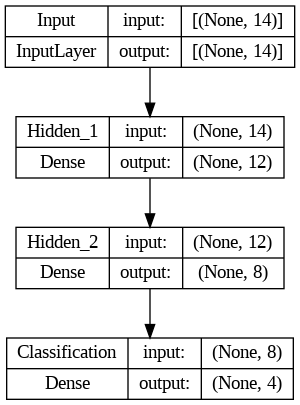

In [105]:
plot_model(mlp_model, show_shapes=True)

In [106]:
loss_fn = SparseCategoricalCrossentropy()
optim_fn = Adam(learning_rate=0.001)
mlp_model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['acc'])

In [107]:
mlp_history = mlp_model.fit(
    x_train_scaled,
    y_train,
    batch_size = 16,
    epochs = 20,
    validation_data = (x_val_scaled, y_val)
)

Epoch 1/20
192/192 [==============================] - 2s 3ms/step - loss: 0.7983 - acc: 0.7120 - val_loss: 0.4623 - val_acc: 0.8558
Epoch 2/20
192/192 [==============================] - 0s 2ms/step - loss: 0.2505 - acc: 0.9709 - val_loss: 0.1050 - val_acc: 0.9815
Epoch 3/20
192/192 [==============================] - 0s 2ms/step - loss: 0.0686 - acc: 0.9909 - val_loss: 0.0434 - val_acc: 0.9945
Epoch 4/20
192/192 [==============================] - 0s 2ms/step - loss: 0.0338 - acc: 0.9967 - val_loss: 0.0243 - val_acc: 0.9963
Epoch 5/20
192/192 [==============================] - 0s 2ms/step - loss: 0.0213 - acc: 0.9980 - val_loss: 0.0152 - val_acc: 0.9982
Epoch 6/20
192/192 [==============================] - 0s 2ms/step - loss: 0.0147 - acc: 0.9980 - val_loss: 0.0103 - val_acc: 1.0000
Epoch 7/20
192/192 [==============================] - 0s 2ms/step - loss: 0.0099 - acc: 0.9993 - val_loss: 0.0090 - val_acc: 1.0000
Epoch 8/20
192/192 [==============================] - 0s 2ms/step - loss: 0.

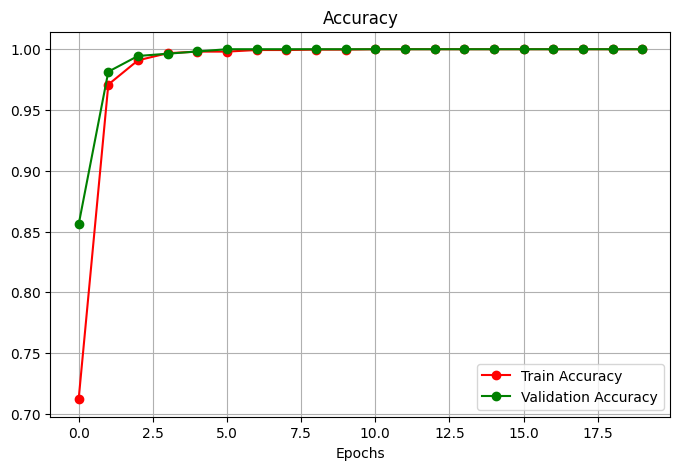

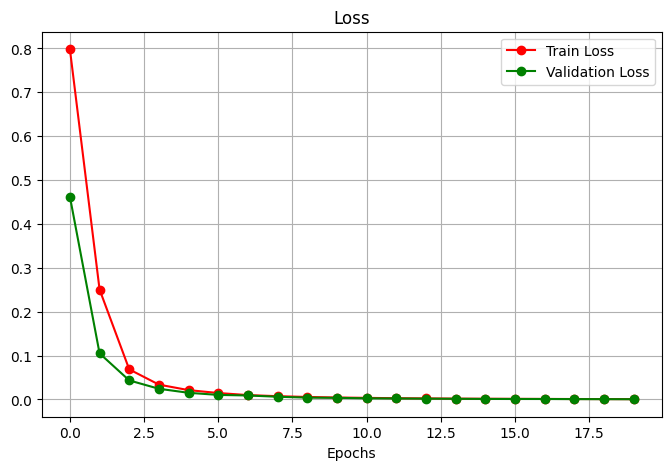

In [108]:
# Train
train_acc = mlp_history.history['acc']
train_loss = mlp_history.history['loss']
# Validation
val_acc = mlp_history.history['val_acc']
val_loss = mlp_history.history['val_loss']

# Plotting section
# Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_acc, 'r-o', label='Train Accuracy')
plt.plot(val_acc, 'g-o', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
# Loss
plt.figure(figsize=(8,5))
plt.plot(train_loss, 'r-o', label='Train Loss')
plt.plot(val_loss, 'g-o', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()

In [109]:
y_hat_train_ = mlp_model.predict(x_train_scaled)
y_hat_train = np.argmax(y_hat_train_, axis=1)
y_hat_val_ = mlp_model.predict(x_val_scaled)
y_hat_val = np.argmax(y_hat_val_, axis=1)

17/17 [==============================] - 0s 2ms/step


In [110]:
target_names = ['normal', 'inner brace fault', 'ball fault', 'outter brace fault']

report_train = classification_report(y_train, y_hat_train, target_names = target_names)
report_val = classification_report(y_val, y_hat_val, target_names = target_names)

print('Classification report for Train data is:\n')
print(report_train, end='\n\n')
print('Classification report for Validation data is:\n')
print(report_val, end='\n\n')

Classification report for Train data is:

                    precision    recall  f1-score   support

            normal       1.00      1.00      1.00       759
 inner brace fault       1.00      1.00      1.00       782
        ball fault       1.00      1.00      1.00       754
outter brace fault       1.00      1.00      1.00       768

          accuracy                           1.00      3063
         macro avg       1.00      1.00      1.00      3063
      weighted avg       1.00      1.00      1.00      3063


Classification report for Validation data is:

                    precision    recall  f1-score   support

            normal       1.00      1.00      1.00       142
 inner brace fault       1.00      1.00      1.00       119
        ball fault       1.00      1.00      1.00       147
outter brace fault       1.00      1.00      1.00       133

          accuracy                           1.00       541
         macro avg       1.00      1.00      1.00       541
     

Text(0.5, 1.0, 'Validation data confusion matrix')

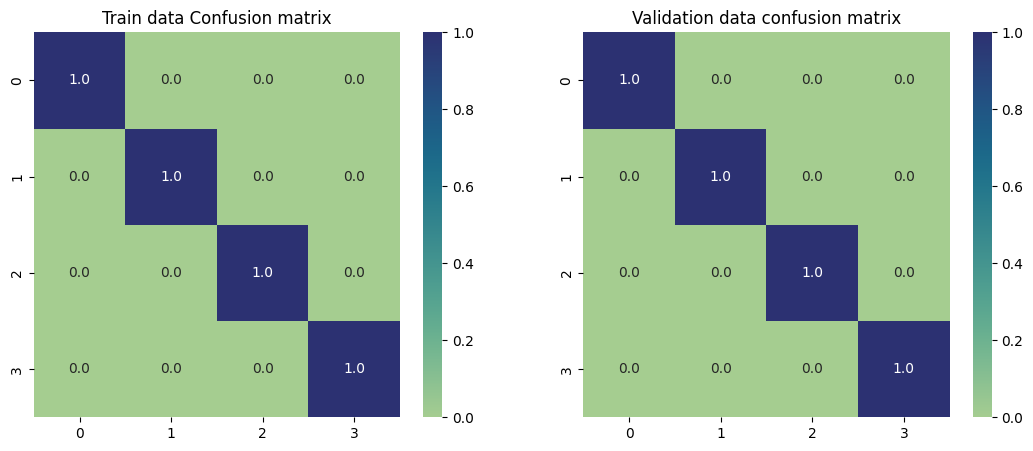

In [111]:
cm_train = confusion_matrix(y_train, y_hat_train)
cm_train_s = np.sum(cm_train,axis=1).reshape(-1,1)
cm_train = cm_train/cm_train_s

cm_val = confusion_matrix(y_val, y_hat_val)
cm_val_s = np.sum(cm_val,axis=1).reshape(-1,1)
cm_val = cm_val/cm_val_s

# Plotting
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot=True, cmap="crest", fmt='.1f')
plt.title('Train data Confusion matrix')

plt.subplot(1,2,2)
sns.heatmap(cm_val,  annot=True, cmap="crest", fmt='.1f')
plt.title('Validation data confusion matrix')

In [112]:
y_hat_test_ = mlp_model.predict(x_test_scaled)
y_hat_test = np.argmax(y_hat_test_, axis=1)

13/13 [==============================] - 0s 2ms/step


In [113]:
report_test = classification_report(y_test, y_hat_test, target_names = target_names)

print('Classification report for Test data is:\n')
print(report_test)

Classification report for Test data is:

                    precision    recall  f1-score   support

            normal       1.00      1.00      1.00        99
 inner brace fault       0.99      1.00      0.99        99
        ball fault       1.00      1.00      1.00        99
outter brace fault       1.00      0.99      0.99        99

          accuracy                           1.00       396
         macro avg       1.00      1.00      1.00       396
      weighted avg       1.00      1.00      1.00       396



Text(0.5, 1.0, 'Test data Confusion matrix')

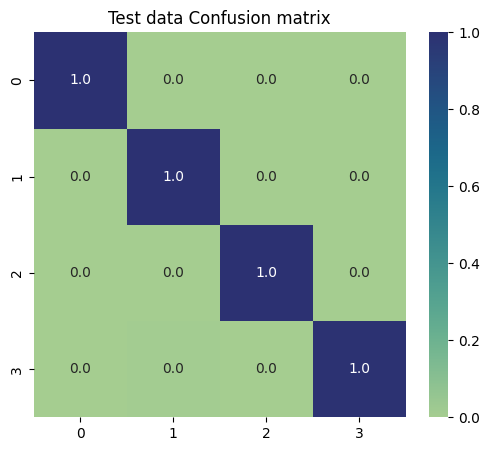

In [114]:
cm_test = confusion_matrix(y_test, y_hat_test)
cm_test_s = np.sum(cm_test, axis=1).reshape(-1,1)
cm_test = cm_test/cm_test_s

# Plotting
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, cmap="crest", fmt='.1f')
plt.title('Test data Confusion matrix')

## Part 2


In [115]:
# Turn 1-D array into one-hot-encoded labels
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)


# compile the model
loss_fn_1 = KLDivergence()
optimizer_1 = SGD(learning_rate=0.001)
mlp_model_1.compile(
    loss = loss_fn_1,
    optimizer = optimizer_1,
    metrics = 'acc'
)

In [116]:
mlp_history_1 = mlp_model_1.fit(
    x_train_scaled,
    y_train_one_hot,
    batch_size = 16,
    epochs = 20,
    validation_data = (x_val_scaled, y_val_one_hot)
)

Epoch 1/20
192/192 [==============================] - 2s 4ms/step - loss: 1.4202 - acc: 0.3082 - val_loss: 1.3457 - val_acc: 0.3420
Epoch 2/20
192/192 [==============================] - 1s 3ms/step - loss: 1.2505 - acc: 0.4845 - val_loss: 1.1984 - val_acc: 0.6081
Epoch 3/20
192/192 [==============================] - 0s 2ms/step - loss: 1.1323 - acc: 0.6765 - val_loss: 1.1015 - val_acc: 0.6506
Epoch 4/20
192/192 [==============================] - 0s 2ms/step - loss: 1.0507 - acc: 0.6161 - val_loss: 1.0257 - val_acc: 0.6137
Epoch 5/20
192/192 [==============================] - 0s 2ms/step - loss: 0.9789 - acc: 0.5939 - val_loss: 0.9535 - val_acc: 0.6137
Epoch 6/20
192/192 [==============================] - 0s 2ms/step - loss: 0.9105 - acc: 0.6177 - val_loss: 0.8849 - val_acc: 0.6488
Epoch 7/20
192/192 [==============================] - 0s 2ms/step - loss: 0.8470 - acc: 0.6526 - val_loss: 0.8216 - val_acc: 0.6950
Epoch 8/20
192/192 [==============================] - 0s 2ms/step - loss: 0.

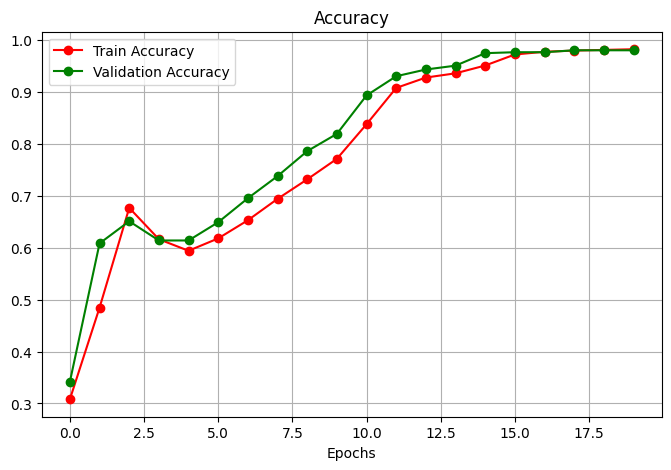

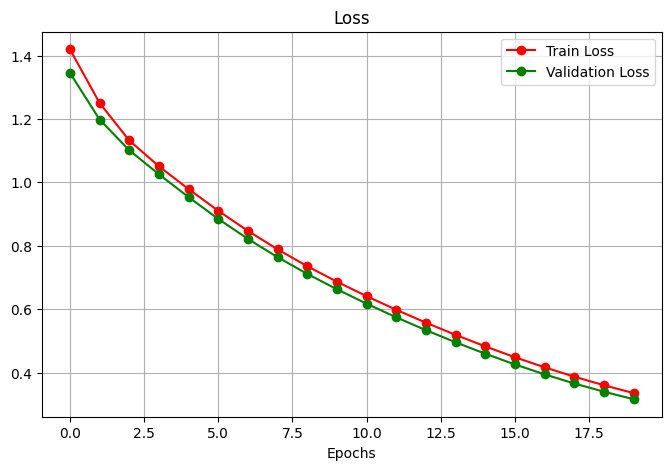

In [117]:
# Train
train_acc = mlp_history_1.history['acc']
train_loss = mlp_history_1.history['loss']
# Validation
val_acc = mlp_history_1.history['val_acc']
val_loss = mlp_history_1.history['val_loss']

# Plotting section
# Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_acc, 'r-o', label='Train Accuracy')
plt.plot(val_acc, 'g-o', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
# Loss
plt.figure(figsize=(8,5))
plt.plot(train_loss, 'r-o', label='Train Loss')
plt.plot(val_loss, 'g-o', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()

In [118]:
y_hat_train_ = mlp_model_1.predict(x_train_scaled)
y_hat_train = np.argmax(y_hat_train_, axis=1)
y_hat_val_ = mlp_model_1.predict(x_val_scaled)
y_hat_val = np.argmax(y_hat_val_, axis=1)

17/17 [==============================] - 0s 1ms/step


In [119]:
from sklearn.metrics import classification_report

target_names = ['normal', 'inner brace fault', 'ball fault', 'outter brace fault']

report_train = classification_report(y_train, y_hat_train, target_names = target_names)
report_val = classification_report(y_val, y_hat_val, target_names = target_names)

print('Classification report for Train data is:\n')
print(report_train, end='\n\n')
print('Classification report for Validation data is:\n')
print(report_val, end='\n\n')

Classification report for Train data is:

                    precision    recall  f1-score   support

            normal       1.00      0.97      0.98       759
 inner brace fault       0.97      0.99      0.98       782
        ball fault       0.97      1.00      0.98       754
outter brace fault       1.00      0.97      0.98       768

          accuracy                           0.98      3063
         macro avg       0.98      0.98      0.98      3063
      weighted avg       0.98      0.98      0.98      3063


Classification report for Validation data is:

                    precision    recall  f1-score   support

            normal       1.00      0.96      0.98       142
 inner brace fault       0.95      1.00      0.98       119
        ball fault       0.97      1.00      0.98       147
outter brace fault       1.00      0.95      0.98       133

          accuracy                           0.98       541
         macro avg       0.98      0.98      0.98       541
     

Text(0.5, 1.0, 'Validation data confusion matrix')

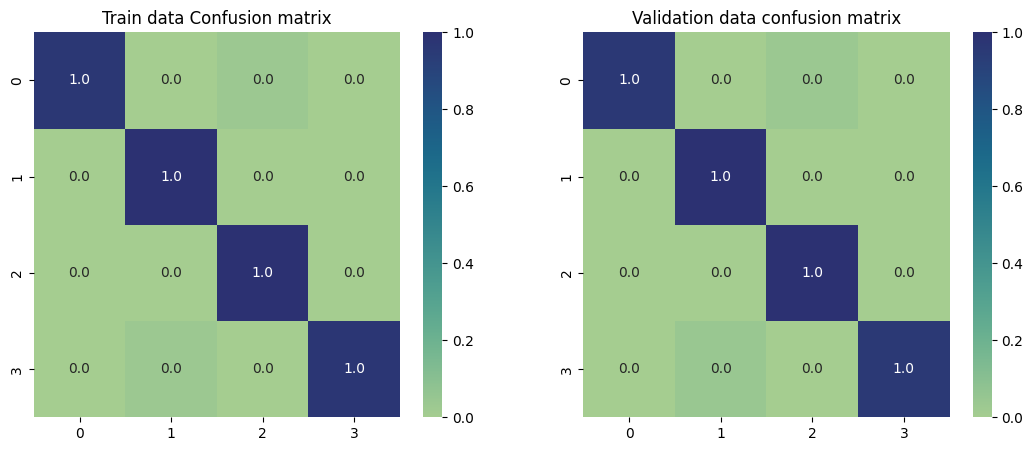

In [120]:
cm_train = confusion_matrix(y_train, y_hat_train)
cm_train_s = np.sum(cm_train,axis=1).reshape(-1,1)
cm_train = cm_train/cm_train_s

cm_val = confusion_matrix(y_val, y_hat_val)
cm_val_s = np.sum(cm_val,axis=1).reshape(-1,1)
cm_val = cm_val/cm_val_s

# Plotting
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train, annot=True, cmap="crest", fmt='.1f')
plt.title('Train data Confusion matrix')

plt.subplot(1,2,2)
sns.heatmap(cm_val,  annot=True, cmap="crest", fmt='.1f')
plt.title('Validation data confusion matrix')

In [121]:
y_hat_test_ = mlp_model_1.predict(x_test_scaled)
y_hat_test = np.argmax(y_hat_test_, axis=1)

13/13 [==============================] - 0s 2ms/step


In [122]:
report_test = classification_report(y_test, y_hat_test, target_names = target_names)

print('Classification report for Test data is:\n')
print(report_test)

Classification report for Test data is:

                    precision    recall  f1-score   support

            normal       1.00      1.00      1.00        99
 inner brace fault       1.00      0.59      0.74        99
        ball fault       1.00      1.00      1.00        99
outter brace fault       0.71      1.00      0.83        99

          accuracy                           0.90       396
         macro avg       0.93      0.90      0.89       396
      weighted avg       0.93      0.90      0.89       396



Text(0.5, 1.0, 'Test data Confusion matrix')

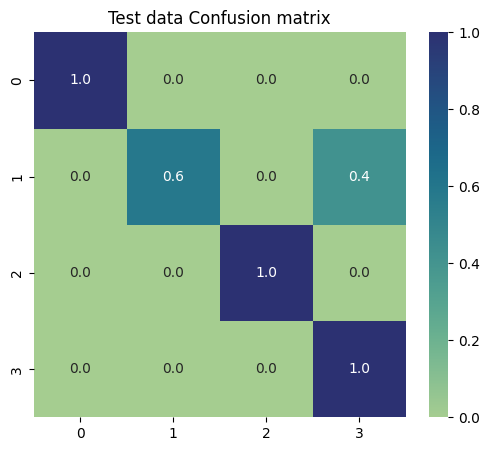

In [123]:
cm_test = confusion_matrix(y_test, y_hat_test)
cm_test_s = np.sum(cm_test, axis=1).reshape(-1,1)
cm_test = cm_test/cm_test_s

# Plotting
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, cmap="crest", fmt='.1f')
plt.title('Test data Confusion matrix')

## Stratified K-Fold Cross-validation

In [124]:
# Define the network
def network():

    # Model architecture
    model = Sequential(
        [
            Input(shape=(14,), name='Input'),
            Dense(units=12, activation='relu', name='Hidden_1'),
            Dense(units=8, activation='relu', name='Hidden_2'),
            Dense(units=4, activation='softmax', name='Classification')
        ]
    )
    # Compiling model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=SparseCategoricalCrossentropy()
    )

    return model

In [125]:
# K-fold model
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)

fold_acc = {'train':[], 'val':[]}
fold_loss = {'train':[], 'val':[]}
all_models = []
all_losses = []

# Train model
for train_index, val_index in tqdm.tqdm(kf.split(x_train_scaled,y_train)):
    X_train_fold, X_val_fold = x_train_scaled[train_index], x_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train selected folds
    model = network()
    history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=16, verbose=0, validation_data=(X_val_fold, y_val_fold))

    # Accuracy
    train_hat = model.predict(X_train_fold, verbose=0)
    train_hat = np.argmax(train_hat,axis=1).reshape(-1,)
    train_hat = train_hat == y_train_fold
    train_score = np.sum(train_hat.astype('float64'))/len(y_train_fold)
    fold_acc['train'].append(train_score)

    val_hat = model.predict(X_val_fold, verbose=0)
    val_hat = np.argmax(val_hat, axis=1).reshape(-1,)
    val_hat = val_hat == y_val_fold
    val_score = np.sum(val_hat.astype('float64'))/len(y_val_fold)
    fold_acc['val'].append(val_score)

    # Loss
    train_loss = history.history['loss'][-1]
    fold_loss['train'].append(train_loss)

    val_loss = history.history['val_loss'][-1]
    fold_loss['val'].append(val_loss)

    # Saving all models
    all_models.append(model)
    all_losses.append(val_loss)



5it [00:42,  8.49s/it]


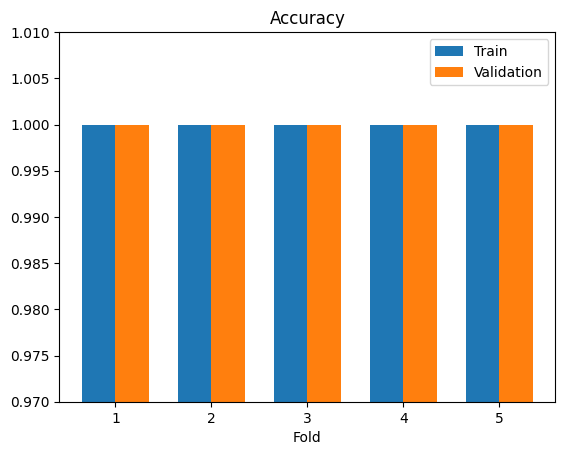

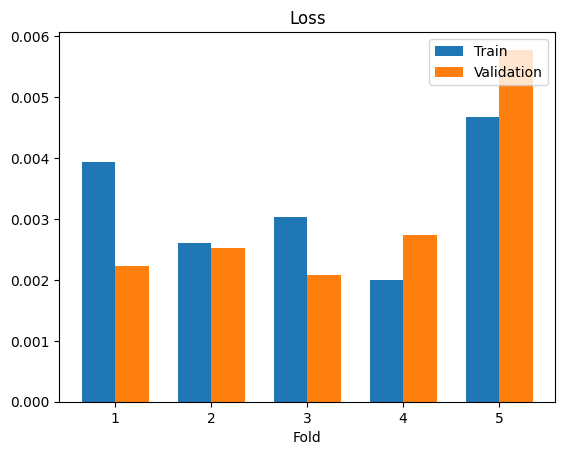

In [126]:
x_axis = np.array(list(range(5))).astype('float32') + 1
width = 0.35

# Accuracy
fig, ax = plt.subplots()
plt.bar(x_axis-width/2, fold_acc['train'], width, label='Train')
plt.bar(x_axis+width/2, fold_acc['val'], width, label='Validation')
plt.title('Accuracy')
plt.xlabel('Fold')
plt.legend(loc='upper right')
plt.ylim([0.97,1.01])

# Loss
fig, ax = plt.subplots()
plt.bar(x_axis-width/2, fold_loss['train'], width, label='Train')
plt.bar(x_axis+width/2, fold_loss['val'], width, label='Validation')
plt.title('Loss')
plt.xlabel('Fold')
plt.legend(loc='upper right')
# plt.ylim([0.97,1.01])


In [127]:
best = np.argmin(all_losses)
y_hat_test_2_ = all_models[best].predict(x_test_scaled)
y_hat_test_2 = np.argmax(y_hat_test_2_, axis=1)

13/13 [==============================] - 0s 2ms/step


In [128]:
final_model_test = classification_report(y_test, y_hat_test_2)

print('Classification report for Test data is:\n')
print(final_model_test)

Classification report for Test data is:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        99
         1.0       1.00      1.00      1.00        99
         2.0       1.00      1.00      1.00        99
         3.0       1.00      1.00      1.00        99

    accuracy                           1.00       396
   macro avg       1.00      1.00      1.00       396
weighted avg       1.00      1.00      1.00       396

